## Data Shift Exploration

Mocking labeled revisions so that rev-scoring can be applied.


#### More on ORES filters:

https://www.mediawiki.org/wiki/ORES/RCFilters

[Enwiki ORES model statistics and filter settings](https://en.wikipedia.org/wiki/Special:ORESModels)

#### Analysis plan:

Basic intuition:

For continuous variables, use the two-sample K-S test.
For binary variables, use the two-sample Chi Squared.  (Could consider a G-test instead...)

To compare source and target distribution, conduct a test for each variable independently.  Then, apply Bonf. correction for the multiple comparisons (Bonf. correction equal to the number of variables.)
Then, reject the null hypothesis if the minimum p-value among all tests is less than 0.05/K (K is number of tests).
Thus, ANY significant difference after correction is taken to be evidence of distribution shift.


How to measure magnitude?
This is a hard problem... Could sum the Earth Mover's Distance, perhaps?  But, would want to normalize by the range of the feature in some way.
I need to do more reading about how to quantify the magnitude of a data shift.
Could use multivariate KL divergence?

Could also use a Multivariate test:
Consider either Maximum Mean Discrepancy (as Lipton used) or Cramer's test: https://cran.r-project.org/web/packages/cramer/cramer.pdf

Should also train a classifier 

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import mwapi
import mwxml
import mwxml.utilities
import mwcli
import mwreverts
import oresapi
import mwparserfromhell

In [3]:
import os
import requests
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter
import time

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [5]:
working_dir = os.path.join(git_root_dir, 'data/derived/data-shifts')
os.makedirs(working_dir, exist_ok=True)

In [6]:
revisions_features_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.20k_2015.damaging.tsv")
assert os.path.exists(revisions_features_filepath)

### Load training features

In [7]:
features_df = pd.read_csv(revisions_features_filepath, sep='\t', header=0)
len(features_df)

19348

In [8]:
rev_list = []
revisions_with_cache_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.w_cache.20k_2015.json")
with open(revisions_with_cache_filepath, 'r') as infile:
    for line in infile:
        rev = json.loads(line)
        rev_list.append({
            'rev_id': rev['rev_id'],
            'damaging': rev['damaging'],
            'goodfaith': rev['goodfaith']
        })
df = pd.DataFrame(rev_list)
len(df)

19348

In [9]:
df = pd.concat([df, features_df], axis=1)

In [10]:
# Load in the labeled revisions content data
labeled_revs_dir = os.path.join(git_root_dir, "data/derived/labeled-revs")
labeled_revs_filepath = os.path.join(labeled_revs_dir, 'labeled_revisions.20k_2015.content.ndjson')
results = []
with open(labeled_revs_filepath, 'r') as infile:
    for line in infile:
        result = json.loads(line)
        results.append(result)

#Identify revision ids for which content is available
rev_ids_with_content = set()
for result in results:
    for page in result['pages']:
        for rev in page['revisions']:
            rev_id = rev['revid']
            rev_ids_with_content.add(rev_id)
df['has_content'] = df.rev_id.map(lambda rev_id: rev_id in rev_ids_with_content)
f"{np.sum(df.has_content)} / {len(df)} ({np.sum(df.has_content) / len(df)*100:.2f}%) training revisions have associated content."

'19344 / 19348 (99.98%) training revisions have associated content.'

In [11]:
#features_df = df.loc[df.has_content,features_df.columns]
features_df.shape

(19348, 81)

In [11]:
should_filter_to_sample1_criteria = False
if should_filter_to_sample1_criteria:
    rev_ids_meeting_criteria = set()
    for result in results:
        for page in result['pages']:
            if page['ns'] != 0 or 'redirect' in page:
                continue
            for rev in page['revisions']:
                rev_id = rev['revid']
                rev_ids_meeting_criteria.add(rev_id)
    df['meets_criteria'] = df.rev_id.map(lambda rev_id: rev_id in rev_ids_meeting_criteria)
    print(len(rev_ids_meeting_criteria))
    
    features_df = df.loc[df.meets_criteria,features_df.columns]
    print(features_df.shape)

13559

### Load sample1 features

In [12]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
mock_features_filepath = os.path.join(git_root_dir, "data/derived/labeled-revs/sample1.mock.damaging.tsv")

In [13]:
mock_features_df = pd.read_csv(mock_features_filepath, sep='\t', header=0)
len(mock_features_df)

458449

### Load month_sample features

In [14]:
month_sample_features_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_features"
month_sample_filepath = os.path.join(month_sample_features_dir, "rev_ids_month_sample_2015_01.mock.damaging.tsv")

In [15]:
month_sample_df = pd.read_csv(month_sample_filepath, sep='\t', header=0)
len(month_sample_df)

99789

In [12]:
# load all the month feature dataframes
month_sample_features_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/month_sample/revscoring_features"
year = 2014
month = 4
month_id_list = []
month_feature_df_list = []
while year != 2020:
    month_sample_filepath = os.path.join(month_sample_features_dir, 
                                         f"rev_ids_month_sample_{year}_{month:0>2}.mock.damaging.tsv")
    assert os.path.exists(month_sample_filepath), f"Path '{month_sample_filepath}' not found."
    month_features_df = pd.read_csv(month_sample_filepath, sep='\t', header=0)
    assert len(month_features_df >= 19800)
    month_id_list.append(int(f"{year}{month:0>2}"))
    month_feature_df_list.append(month_features_df)
    month += 1
    if month == 13:
        month = 1
        year += 1

In [13]:
# total revisions across the month sample
sum(map(len, month_feature_df_list))

1374901

### Multiple Univariate Testing

In [69]:
# define source and target dataframes
sdf = features_df.drop(columns='damaging')
#tdf = month_sample_df.drop(columns='damaging')
tdf = mock_features_df.drop(columns='damaging')

In [70]:
sdf.shape, tdf.shape

((13529, 80), (458449, 80))

In [56]:
sdf.dtypes

feature.revision.page.is_articleish                                                   bool
feature.revision.page.is_mainspace                                                    bool
feature.revision.page.is_draftspace                                                   bool
feature.log((wikitext.revision.parent.chars + 1))                                  float64
feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1))    float64
                                                                                    ...   
feature.english.dictionary.revision.diff.non_dict_word_delta_increase                int64
feature.english.dictionary.revision.diff.non_dict_word_delta_decrease                int64
feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum              float64
feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase         float64
feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease         float64

In [57]:
n_features = len(sdf.columns)
univariate_results = []
for col_name, col_dtype in zip(sdf.columns, sdf.dtypes):
    is_feature_binary = False
    std = 0
    if col_dtype == bool:
        is_feature_binary  = True
        s_true_count = np.sum(sdf[col_name])
        s_false_count = len(sdf) - s_true_count
        t_true_count = np.sum(tdf[col_name])
        t_false_count = len(tdf) - t_true_count
        if s_true_count == 0 or s_false_count == 0 or t_true_count == 0 or t_false_count == 0:
            p = n_features
            diff = (t_true_count / len(tdf)) - (s_true_count / len(sdf))
        else:
            cont = np.array(
                [[s_true_count, s_false_count],
                 [t_true_count, t_false_count]]
            )
            chi2, p, dof, expctd = scipy.stats.chi2_contingency(cont)
            p = p * n_features
        diff = (t_true_count / len(tdf)) - (s_true_count / len(sdf))
    else:
        D, p = scipy.stats.ks_2samp(sdf[col_name], tdf[col_name])
        p = p * n_features
        diff = np.mean(tdf[col_name]) - np.mean(sdf[col_name])
        std = np.std(np.concatenate((sdf[col_name], tdf[col_name])))
    pre_mean = np.mean(sdf[col_name])
    _, mean_diff_p = scipy.stats.ttest_ind(sdf[col_name], tdf[col_name], equal_var=False)
    mean_diff_p *= n_features
    tup = (col_name, is_feature_binary, p, diff, std, pre_mean, diff / pre_mean, mean_diff_p)
    univariate_results.append(tup)
univariate_results.sort(key=lambda tup: (tup[1], abs(tup[2]), -abs(tup[6])), reverse=False)
print(f"{'Feature Name':<71} {'Feat. Type':>10} {'p-value':>7} {'S'} {'T'} {'Diff':>6}")
print("="*100)
for tup in univariate_results:
    col_name, is_feature_binary, p, diff, std, pre_mean, pct_change, mean_diff_p = tup
    print(f"{col_name[8:]:<71} {'binary' if is_feature_binary else 'continuous':>10} {p:7.3f} {'Y' if p < 0.001 else '-'} {'Y' if mean_diff_p < 0.001 else '-'} {diff:6.2f} ({pre_mean:.2f}) {pct_change*100:.1f}%")


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


Feature Name                                                            Feat. Type p-value S T   Diff
log((wikitext.revision.parent.ref_tags + 1))                            continuous   0.000 Y Y   0.92 (2.32) 39.7%
log((wikitext.revision.parent.external_links + 1))                      continuous   0.000 Y Y   0.87 (2.28) 38.1%
log((wikitext.revision.parent.templates + 1))                           continuous   0.000 Y Y   0.98 (3.02) 32.4%
log((wikitext.revision.parent.headings + 1))                            continuous   0.000 Y Y   0.47 (2.11) 22.2%
log((wikitext.revision.parent.wikilinks + 1))                           continuous   0.000 Y Y   0.73 (4.12) 17.7%
log((len(<datasource.wikitext.revision.parent.words>) + 1))             continuous   0.000 Y Y   0.90 (6.97) 12.9%
log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)) continuous   0.000 Y Y   0.93 (8.01) 11.6%
log((wikitext.revision.parent.chars + 1))                               continuous   0.000 Y 

### Multivariate testing

Multivariate kernel two-sample tests

To get a p-value directly comparing the two samples, using Maximum Mean Discrepancy or some other test.

TODO Do this in R lol, no fast Python implementation exists as far as I can tell.

We could also use Hotelling's $T^2$ test, which is implemented in the Hotelling R package, and basically serves as a high-level difference in mean.

In [67]:
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/data-shifts'

In [76]:
start = datetime.now()
(sdf.sample(n=10000)*1).to_csv(os.path.join(working_dir, 'sdf.csv'), index=False, header=True)
(tdf.sample(n=10000)*1).to_csv(os.path.join(working_dir, 'tdf.csv'), index=False, header=True)
print(f"Finished writing in {datetime.now() - start}.")

Finished writing in 0:00:01.645008.


### Compute level of difference

In [14]:
def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
    y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
    Returns
    -------
    out : float
    The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions IEEE International Symposium on Information
    Theory, 2008.
    
    https://gist.github.com/atabakd/ed0f7581f8510c8587bc2f41a094b518
    """
    from scipy.spatial import cKDTree as KDTree

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [15]:
sdf = features_df.drop(columns='damaging')
sdf.to_numpy().shape

(19348, 80)

In [45]:
# compute K-L divergence between the training data and each of the months in the month sample
month_sample_kld_mean_list = []
month_sample_kld_std_list = []
for month_features_df in tqdm(month_feature_df_list):
    tdf = month_features_df.drop(columns='damaging')
    kl_sample_n = 10000
    n_iters = 3
    kld_list = []
    for i in range(n_iters):
        kld = KLdivergence(sdf.sample(n=kl_sample_n).to_numpy(), (tdf.sample(n=kl_sample_n) + 0.0000000001).to_numpy())
        kld_list.append(kld)
    month_sample_kld_mean_list.append(np.mean(kld_list))
    month_sample_kld_std_list.append(np.std(kld_list))

100%|██████████| 69/69 [1:12:15<00:00, 62.83s/it] 


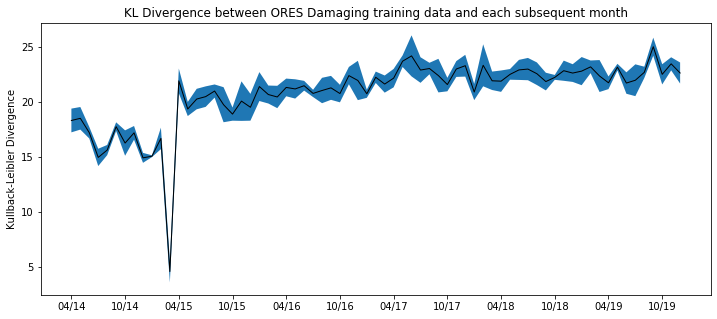

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

x = range(len(month_sample_kld_mean_list))
assert len(x) == len(month_id_list)
ax.plot(x, month_sample_kld_mean_list, color='black', linewidth=1)

bottom = np.array(month_sample_kld_mean_list) - np.array(month_sample_kld_std_list)
top = np.array(month_sample_kld_mean_list) + np.array(month_sample_kld_std_list)
ax.fill_between(x, bottom, top)

xticks = x[::6]
xtick_labels = [str(month_id)[4:] + "/" + str(month_id)[2:4] for month_id in month_id_list[::6]]
assert len(xticks) == len(xtick_labels), len(xtick_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_title("KL Divergence between ORES Damaging training data and each subsequent month")
ax.set_ylabel("Kullback-Leibler Divergence")
plt.show()

In [52]:
min(month_sample_kld_mean_list)

4.5622410381974605

In [101]:
# load from file
training_kld_filepath = os.path.join(working_dir, "month_sample_training_kld.csv")
kld_df = pd.read_csv(training_kld_filepath, header=None).rename(columns={0: 'month_id'})
kld_df.head(n=2)

,month_id,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,201404,21.037454,17.210126,19.567396,19.055749,18.771487,19.044875,18.838193,18.454050,18.703005,...,18.782197,19.824913,19.972965,19.226841,19.214092,18.137879,17.578106,19.235859,17.971226,18.404071
1,201405,20.233406,16.378007,20.665039,16.725724,17.629825,17.042177,17.585749,18.124163,17.957113,...,16.886185,19.908486,18.567806,18.217750,20.193569,18.003000,17.409095,18.310904,18.086647,17.608563


In [102]:
# load from second file
training_kld_filepath = os.path.join(working_dir, "month_sample_training_kld_200.csv")
kld_df2 = pd.read_csv(training_kld_filepath, header=None).rename(columns={0: 'month_id'})
kld_df2.shape

(69, 201)

In [103]:
kld_df = kld_df.merge(kld_df2, on='month_id')

In [104]:
# remove the month_id identifier column
kld_df = kld_df.iloc[:,1:]
kld_df.shape

(69, 300)

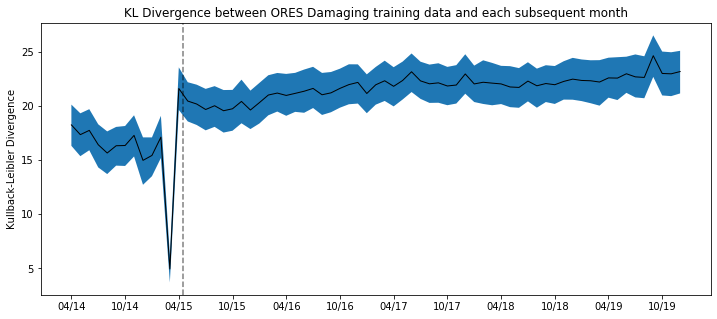

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

x = range(len(kld_df))
assert len(x) == len(month_id_list)
means = kld_df.mean(axis=1)
ax.plot(x, means, color='black', linewidth=1)

bottom = kld_df.quantile(q=0.05, axis=1)
top = kld_df.quantile(q=0.95, axis=1)
ax.fill_between(x, bottom, top)

# mark the end of the training period with a line
plt.axvline(12.5, color='black', linestyle='--', alpha=0.5)

xticks = x[::6]
xtick_labels = [str(month_id)[4:] + "/" + str(month_id)[2:4] for month_id in month_id_list[::6]]
assert len(xticks) == len(xtick_labels), len(xtick_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_title("KL Divergence between ORES Damaging training data and each subsequent month")
ax.set_ylabel("Kullback-Leibler Divergence")
plt.show()

#### Downsampled data

In [106]:
# load from file
training_kld_filepath = os.path.join(working_dir, "month_sample_training_downsampled_kld_20.csv")
kld_df = pd.read_csv(training_kld_filepath, header=None).rename(columns={0: 'month_id'})

# load from second file
training_kld_filepath = os.path.join(working_dir, "month_sample_training_downsampled_kld_180.csv")
kld_df2 = pd.read_csv(training_kld_filepath, header=None).rename(columns={0: 'month_id'})

#merge the files
kld_df = kld_df.merge(kld_df2, on='month_id')

# remove the month_id identifier column
kld_df = kld_df.iloc[:,1:]
kld_df.shape

(69, 200)

In [116]:
# load from file
training_kld_filepath = os.path.join(working_dir, "month_sample_training_downsampled_inverse_kld_200.csv")
inverse_kld_df = pd.read_csv(training_kld_filepath, header=None).rename(columns={0: 'month_id'})

# remove the month_id identifier column
inverse_kld_df = inverse_kld_df.iloc[:,1:]

assert len(inverse_kld_df) == len(kld_df)
inverse_kld_df.shape

(69, 200)

In [134]:
means = inverse_kld_df.mean(axis=1)
np.median(inverse_kld_df.iloc[11,:])

104.47449959871324

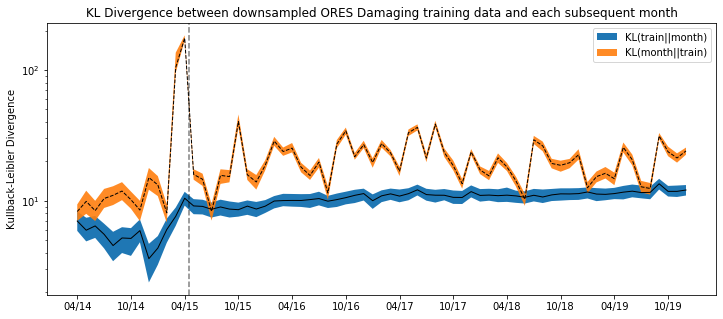

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

x = range(len(kld_df))
assert len(x) == len(month_id_list)
means = kld_df.median(axis=1)
ax.plot(x, means, color='black', linewidth=1)

bottom = kld_df.quantile(q=0.05, axis=1)
top = kld_df.quantile(q=0.95, axis=1)
ax.fill_between(x, bottom, top, label='KL(train||month)')

# now plot inverse KLD
means = inverse_kld_df.median(axis=1)
#means[12] /= 10
ax.plot(x, means, color='black', linewidth=1, linestyle='--')

bottom = inverse_kld_df.quantile(q=0.05, axis=1)
top = inverse_kld_df.quantile(q=0.95, axis=1)
#bottom[12] /= 10
#top[12] /= 10
ax.fill_between(x, bottom, top, label='KL(month||train)', alpha=0.9)

# mark the end of the training period with a line
plt.axvline(12.5, color='black', linestyle='--', alpha=0.5)

xticks = x[::6]
xtick_labels = [str(month_id)[4:] + "/" + str(month_id)[2:4] for month_id in month_id_list[::6]]
assert len(xticks) == len(xtick_labels), len(xtick_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_title("KL Divergence between downsampled ORES Damaging training data and each subsequent month")
ax.set_ylabel("Kullback-Leibler Divergence")

plt.yscale('log')

plt.legend()
plt.show()

### Month-to-month changes

In [147]:
# load from file
training_kld_filepath = os.path.join(working_dir, "month_sample_adjacent_inverse_kld_200.csv")
kld_df = pd.read_csv(training_kld_filepath, header=None).rename(columns={0: 'month_id'})

# remove the month_id identifier column
kld_df = kld_df.iloc[:,1:]
kld_df.shape

(68, 200)

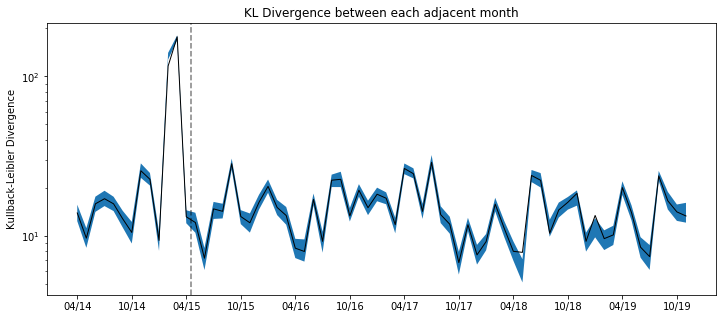

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

x = range(len(kld_df))
assert len(x) == len(month_id_list)-1
means = kld_df.mean(axis=1)
ax.plot(x, means, color='black', linewidth=1)

bottom = kld_df.quantile(q=0.05, axis=1)
top = kld_df.quantile(q=0.95, axis=1)
ax.fill_between(x, bottom, top)

# mark the end of the training period with a line
plt.axvline(12.5, color='black', linestyle='--', alpha=0.5)

xticks = x[::6]
xtick_labels = [str(month_id)[4:] + "/" + str(month_id)[2:4] for month_id in month_id_list[::6]]
assert len(xticks) == len(xtick_labels), len(xtick_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_title("KL Divergence between each adjacent month")
ax.set_ylabel("Kullback-Leibler Divergence")

plt.yscale('log')
plt.show()

In [66]:
len(month_feature_df_list)

69

In [67]:
from scipy.spatial import cKDTree as KDTree

x = month_feature_df_list[0].drop(columns='damaging').sample(n=1000)
y = month_feature_df_list[0].drop(columns='damaging').sample(n=1000)

# Check the dimensions are consistent
x = np.atleast_2d(x)
y = np.atleast_2d(y)

n,d = x.shape
m,dy = y.shape

assert(d == dy)

# Build a KD tree representation of the samples and find the nearest neighbour
# of each point in x.
xtree = KDTree(x)
ytree = KDTree(y)

# Get the first two nearest neighbours for x, since the closest one is the
# sample itself.
r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
s = ytree.query(x, k=1, eps=.01, p=2)[0]

# There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
# on the first term of the right hand side.
kld = -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))
kld

/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


-inf

In [80]:
eta = 0.000000000001
r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
s = ytree.query(x, k=1, eps=.01, p=2)[0]
s[s==0] = eta
assert np.all(s != 0)
np.log(r/s, )

array([ 1.09885141e-01, -3.01573405e-02,  0.00000000e+00, -9.77272266e-02,
       -3.94693462e-01, -2.62552344e-01,  3.05517667e-01, -3.25491022e-02,
        3.07091250e+01,  3.49838235e-02,  2.14082574e-01, -1.73617577e-01,
       -1.32708523e-01, -8.17316512e-01, -2.34114163e-01, -5.99857651e-01,
        9.89097434e-01, -5.83680686e-02,  1.00301164e-02,  5.11171536e-01,
        3.01570960e-01, -1.58420455e-01,  2.91070948e+01, -3.52111525e-01,
       -8.57147257e-02,  8.03514308e-02,  2.95673417e+01, -2.57938082e-02,
       -2.58466091e-02, -3.70104013e-01,  1.79436278e-01,  6.44644224e-02,
       -2.33817845e-01, -1.40052788e-01, -3.09335360e-01,  6.69077885e-02,
        6.18409266e-02, -5.42081225e-02, -2.85222090e-01, -2.48555164e-02,
       -3.20307379e-02, -2.42877345e-01,  3.71627024e-01,  1.59864179e-01,
       -2.11766050e-01,  3.75635451e-01,  9.06158283e-02, -3.92722570e-02,
        1.40574108e-01,  1.60541767e+00, -1.30689309e-01,  5.24156201e-02,
        2.89462685e+01,  

In [99]:
x = np.array([0.0, 1, 2, 3])
print(x)
x = np.log(x, where=x > 0)
print(x)

[0. 1. 2. 3.]
[0.         0.         0.69314718 1.09861229]


In [53]:
# compute K-L divergence between the training data and each of the months in the month sample
month_sample_adjacent_kld_mean_list = []
month_sample_adjacent_kld_std_list = []
prev_month_features_df = None
eta =  0.0000000001
for i, month_features_df in tqdm(enumerate(month_feature_df_list)):
    if i == 0:
        prev_month_features_df = month_features_df
        continue
    sdf = prev_month_features_df.drop(columns='damaging')
    tdf = month_features_df.drop(columns='damaging')
    kl_sample_n = 10000
    n_iters = 4
    kld_list = []
    for i in range(n_iters):
        kld = KLdivergence((sdf.sample(n=kl_sample_n) + eta).to_numpy(), (tdf.sample(n=kl_sample_n) + eta).to_numpy())
        kld_list.append(kld)
    month_sample_adjacent_kld_mean_list.append(np.mean(kld_list))
    month_sample_adjacent_kld_std_list.append(np.std(kld_list))
    prev_month_features_df = month_features_df

3it [01:53, 36.60s/it]/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
15it [13:59, 58.34s/it]/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
24it [24:35, 72.53s/it]/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
42it [48:03, 87.04s/it]/export/scratch2/levon003/bin/anac

In [54]:
month_sample_adjacent_kld_mean_list

[8.41227702689142,
 15.118815855753331,
 inf,
 14.151507207223283,
 17.10798847718152,
 14.331139309060335,
 inf,
 9.026313967310086,
 inf,
 19.59833865308581,
 inf,
 inf,
 inf,
 inf,
 -inf,
 inf,
 inf,
 11.413548852467912,
 inf,
 12.057084154207995,
 13.247930944340977,
 -inf,
 18.537034110783196,
 nan,
 -inf,
 inf,
 inf,
 -inf,
 9.773313147880655,
 16.10044135985374,
 25.645735236408722,
 inf,
 18.303414497654842,
 14.662470560371707,
 20.78110668408081,
 inf,
 11.040098211294433,
 26.103956392457434,
 24.883486654933563,
 12.455116985332031,
 27.506570197915735,
 nan,
 inf,
 6.276954272346201,
 11.93451906133297,
 inf,
 10.005179200737722,
 15.079055994414503,
 12.255396597986712,
 9.929064680597476,
 inf,
 24.912621461875155,
 nan,
 14.875657522669481,
 inf,
 15.200750948128922,
 18.75201976965478,
 nan,
 inf,
 inf,
 10.358084255224965,
 16.704013676878553,
 14.826800604409819,
 inf,
 nan,
 17.776629147636417,
 -inf,
 11.860784137573681]

In [52]:
# KL divergence comparing the training data to the April 2015 data
tdf = month_sample_df.drop(columns='damaging')
start = datetime.now()
kl_sample_n = 10000
n_iters = 10
kld_list = []
for i in range(n_iters):
    kld = KLdivergence(sdf.sample(n=kl_sample_n).to_numpy(), (tdf.sample(n=kl_sample_n) + 0.0000000001).to_numpy())
    kld_list.append(kld)
print(f"{datetime.now() - start}")
print(f"{np.mean(kld_list):.2f} w std. {np.std(kld_list):.2f}")

0:03:47.998024
2.02 w std. 0.50


In [53]:
# KL divergence comparing the training data to the sample1 data
tdf = mock_features_df.drop(columns='damaging')
start = datetime.now()
kl_sample_n = 10000
n_iters = 10
kld_list = []
for i in range(n_iters):
    kld = KLdivergence(sdf.sample(n=kl_sample_n).to_numpy(), (tdf.sample(n=kl_sample_n) + 0.0000000001).to_numpy())
    kld_list.append(kld)
print(f"{datetime.now() - start}")
print(f"{np.mean(kld_list):.2f} w std. {np.std(kld_list):.2f}")

0:04:16.450829
6.37 w std. 0.31
